Descomente uma linha da célula abaixo caso seja necessário instalar alguma das bibliotecas.

In [1]:
#!pip install yfinance
#!pip install selenium
#!pip install pandas
#!pip install time

In [2]:
import yfinance as yf
import pandas as pd
import selenium 
import matplotlib.pyplot as plt
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import Select
import time

### Função que obtem as ações que compõem o índice a partir do site da B3

A função "pega_tickers" utiliza a biblioteca selenium para consultar a tabela disponibilizada pela B3 da atual composição do IBRX50.

In [3]:
def pega_tickers():
    #Definição dos objetos para uso da consulta com o navegador chrome.
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_driver_path ="C:\selenium\chromedriver_win32\chromedriver.exe"
    service = Service(executable_path=chrome_driver_path)

    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get('https://sistemaswebb3-listados.b3.com.br/indexPage/day/IBXL?language=pt-br')

    time.sleep(2)
    
    #necessidade de selecionar o botão de visualização para 60 itens, a fim de pegar
    #todos os tickers do índice.
    button = driver.find_elements(By.TAG_NAME,'select')[1]
    for opt in button.find_elements(By.TAG_NAME,'option'):
        if opt.text == '60':
            opt.click()

    time.sleep(2)
    
    #armazenamento do html com a tabela que exibe todos as ações do índice.
    page = driver.page_source

    tabela_acoes = pd.read_html(page)[0]
    #As últimas linhas da tabela não contém as informações dos tickers e a tabala atual possuia apenas 49 ações
    #
    tabela_acoes = tabela_acoes.loc[(tabela_acoes['Código']!= 'Quantidade Teórica Total')&(tabela_acoes['Código']!= 'Redutor')]
    tickers = tabela_acoes['Código'].values
    tickers = [ticker + ".SA" for ticker in tickers]

    return tickers

In [4]:
tickers = pega_tickers()

### Preenchimento dos valores vazios 

A função **fillna_with_neighbor_mean** recebe uma **série de dados** (um conjunto de valores em uma sequência indexados no tempo) como entrada e retorna a mesma série com os **valores faltantes (NaN) preenchidos**.

A função utiliza o método **interpolate** do **Pandas**, que preenche os valores faltantes com base nos valores existentes ao redor do valor faltante. O método **"linear"** utilizado na interpolação significa que os valores faltantes serão preenchidos com base na média dos valores vizinhos, de modo a ignorar os índices.

O parâmetro **limit_direction="both"** indica que a interpolação deve ser aplicada tanto **para frente quanto para trás** na série, ou seja, preenche os valores faltantes considerando os vizinhos à direita e à esquerda do valor faltante.

Em resumo, a função **fillna_with_neighbor_mean** preenche os valores faltantes (NaN) de uma série de dados com a **média dos valores vizinhos.**

In [5]:
start_date = "2018-01-01"
end_date = "2022-01-01"

data = yf.download(tickers, start=start_date, end=end_date)["Close"]

def fillna_with_neighbor_mean(series):
    return series.interpolate(method="linear", limit_direction="both")

data_filled = data.apply(fillna_with_neighbor_mean)

# Verificação de valores vazios
print('Valores vazios antes de preenchimento com interpolação: ')
print(data.isnull().sum())
print('Valores vazios após interpolação: ') 
print(data_filled.isnull().sum())

[*********************100%***********************]  50 of 50 completed
Valores vazios antes de preenchimento com interpolação: 
ABEV3.SA       0
ASAI3.SA     779
AZUL4.SA       0
B3SA3.SA       0
BBAS3.SA       0
BBDC4.SA       0
BBSE3.SA       0
BEEF3.SA       0
BPAC11.SA      0
BRFS3.SA       0
CCRO3.SA       0
CIEL3.SA       0
CMIG4.SA       0
CSAN3.SA       0
CSNA3.SA       0
CYRE3.SA       0
ELET3.SA       0
ELET6.SA       0
EMBR3.SA       0
ENEV3.SA       0
EQTL3.SA       0
GGBR4.SA       0
HAPV3.SA      79
HYPE3.SA       0
ITSA4.SA       0
ITUB4.SA       0
JBSS3.SA       0
KLBN11.SA      0
LREN3.SA       0
MGLU3.SA       0
MRFG3.SA       0
MULT3.SA       0
NTCO3.SA     487
PETR3.SA       0
PETR4.SA       0
PETZ3.SA     670
PRIO3.SA       0
RADL3.SA       0
RAIL3.SA       0
RDOR3.SA     732
RENT3.SA       0
RRRP3.SA     711
SBSP3.SA       0
SUZB3.SA       0
TOTS3.SA       0
USIM5.SA       0
VALE3.SA       0
VBBR3.SA      49
VIIA3.SA       0
WEGE3.SA       0
dtype: int64
Valores v

In [6]:
data_filled

,ABEV3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRFS3.SA,...,RENT3.SA,RRRP3.SA,SBSP3.SA,SUZB3.SA,TOTS3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,21.690001,14.28,27.150000,7.636666,32.930000,19.693554,28.700001,10.708080,4.725000,37.270000,...,21.676189,20.799999,34.599998,18.790001,10.030941,9.60,41.720001,22.629999,7.71,9.623076
2018-01-03,21.740000,14.28,27.059999,7.766666,33.349998,19.773239,28.719999,10.629416,4.770000,37.000000,...,21.971428,20.799999,33.980000,18.650000,10.243869,9.92,41.470001,22.629999,7.75,9.476923
2018-01-04,21.620001,14.28,27.230000,7.816666,33.669998,20.097670,28.780001,10.590085,4.787500,37.400002,...,22.285713,20.799999,33.320000,18.700001,10.180656,10.48,41.639999,22.629999,7.81,9.384615
2018-01-05,21.700001,14.28,27.200001,7.930000,33.669998,20.211506,28.969999,10.708080,4.692500,39.240002,...,21.961905,20.799999,33.700001,18.650000,10.400239,10.03,42.290001,22.629999,7.56,9.423076
2018-01-08,21.660000,14.28,26.910000,7.966666,33.750000,20.205814,29.139999,10.344261,4.750000,39.700001,...,21.857141,20.799999,34.389999,19.100000,10.393585,10.14,43.230000,22.629999,7.69,9.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,15.550000,14.09,26.459999,11.380000,29.219999,17.490910,20.620001,10.530000,21.459999,22.620001,...,54.750000,31.270000,39.889999,60.189999,28.740000,14.86,79.150002,21.040001,4.50,33.470001
2021-12-27,15.530000,13.64,25.670000,11.310000,29.280001,17.690908,20.750000,10.430000,21.480000,22.230000,...,55.049999,31.770000,40.049999,60.340000,28.809999,15.04,78.949997,21.309999,4.86,33.169998
2021-12-28,15.520000,13.10,25.750000,11.160000,29.110001,17.627272,20.790001,10.550000,20.719999,22.590000,...,53.549999,32.070000,40.040001,59.660000,28.320000,14.75,77.050003,21.469999,4.95,33.290001


## Busca de preço ajustado das ações
O preço ajustado é que aquele que se obtem ao descontar o valor distribuído pela empresa em dividendos aos acionistas.

In [7]:
#buscar o preço ajustado com yfinance
data_adj = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
#preenchendo os valores vazios
data_adj_filled = data_adj.apply(fillna_with_neighbor_mean)
# Verificação de valores vazios
print('Valores vazios antes de preenchimento com interpolação:')
print(data_adj.isnull().sum())
print('Valores vazios após interpolação:')
print(data_adj_filled.isnull().sum())

[*********************100%***********************]  50 of 50 completed
Valores vazios antes de preenchimento com interpolação:
ABEV3.SA       0
ASAI3.SA     779
AZUL4.SA       0
B3SA3.SA       0
BBAS3.SA       0
BBDC4.SA       0
BBSE3.SA       0
BEEF3.SA       0
BPAC11.SA      0
BRFS3.SA       0
CCRO3.SA       0
CIEL3.SA       0
CMIG4.SA       0
CSAN3.SA       0
CSNA3.SA       0
CYRE3.SA       0
ELET3.SA       0
ELET6.SA       0
EMBR3.SA       0
ENEV3.SA       0
EQTL3.SA       0
GGBR4.SA       0
HAPV3.SA      79
HYPE3.SA       0
ITSA4.SA       0
ITUB4.SA       0
JBSS3.SA       0
KLBN11.SA      0
LREN3.SA       0
MGLU3.SA       0
MRFG3.SA       0
MULT3.SA       0
NTCO3.SA     487
PETR3.SA       0
PETR4.SA       0
PETZ3.SA     670
PRIO3.SA       0
RADL3.SA       0
RAIL3.SA       0
RDOR3.SA     732
RENT3.SA       0
RRRP3.SA     711
SBSP3.SA       0
SUZB3.SA       0
TOTS3.SA       0
USIM5.SA       0
VALE3.SA       0
VBBR3.SA      49
VIIA3.SA       0
WEGE3.SA       0
dtype: int64
Valores va

In [8]:
#escolhendo um ativo para demonstrar a diferença entre os preços ajustados e não ajustados
ticker = 'ITUB4.SA'
#criando tabelas com os preços ajustado e não ajustado
itub_data = pd.DataFrame()
itub_data['Close'] = data_filled[ticker]
itub_data['Adj Close'] = data_adj_filled[ticker]
itub_data['Diff'] = itub_data['Close'] - itub_data['Adj Close']
itub_data['Diff %'] = itub_data['Diff']/itub_data['Close']*100

In [9]:
#Tabela com análise dos preços
itub_data

,Close,Adj Close,Diff,Diff %
Date,,,,
2018-01-02,29.253332,23.113798,6.139534,20.987469
2018-01-03,29.453333,23.271822,6.181511,20.987475
2018-01-04,30.066666,23.756430,6.310236,20.987482
2018-01-05,30.153334,23.824905,6.328428,20.987491
2018-01-08,30.053333,23.745899,6.307434,20.987469
...,...,...,...,...
2021-12-23,21.340000,19.991472,1.348528,6.319250
2021-12-27,21.559999,20.197569,1.362431,6.319251
2021-12-28,21.480000,20.122620,1.357380,6.319273


In [10]:
#Procura dos dividendos da ação
itub4 = yf.Ticker("ITUB4.SA")
dividends_itub = itub4.history(start = start_date, end =  end_date)['Dividends']

### Plotagem dos gráficos para melhor visualização dos dados para comparação entre o Preço de Fechamento e o Preço Ajustado

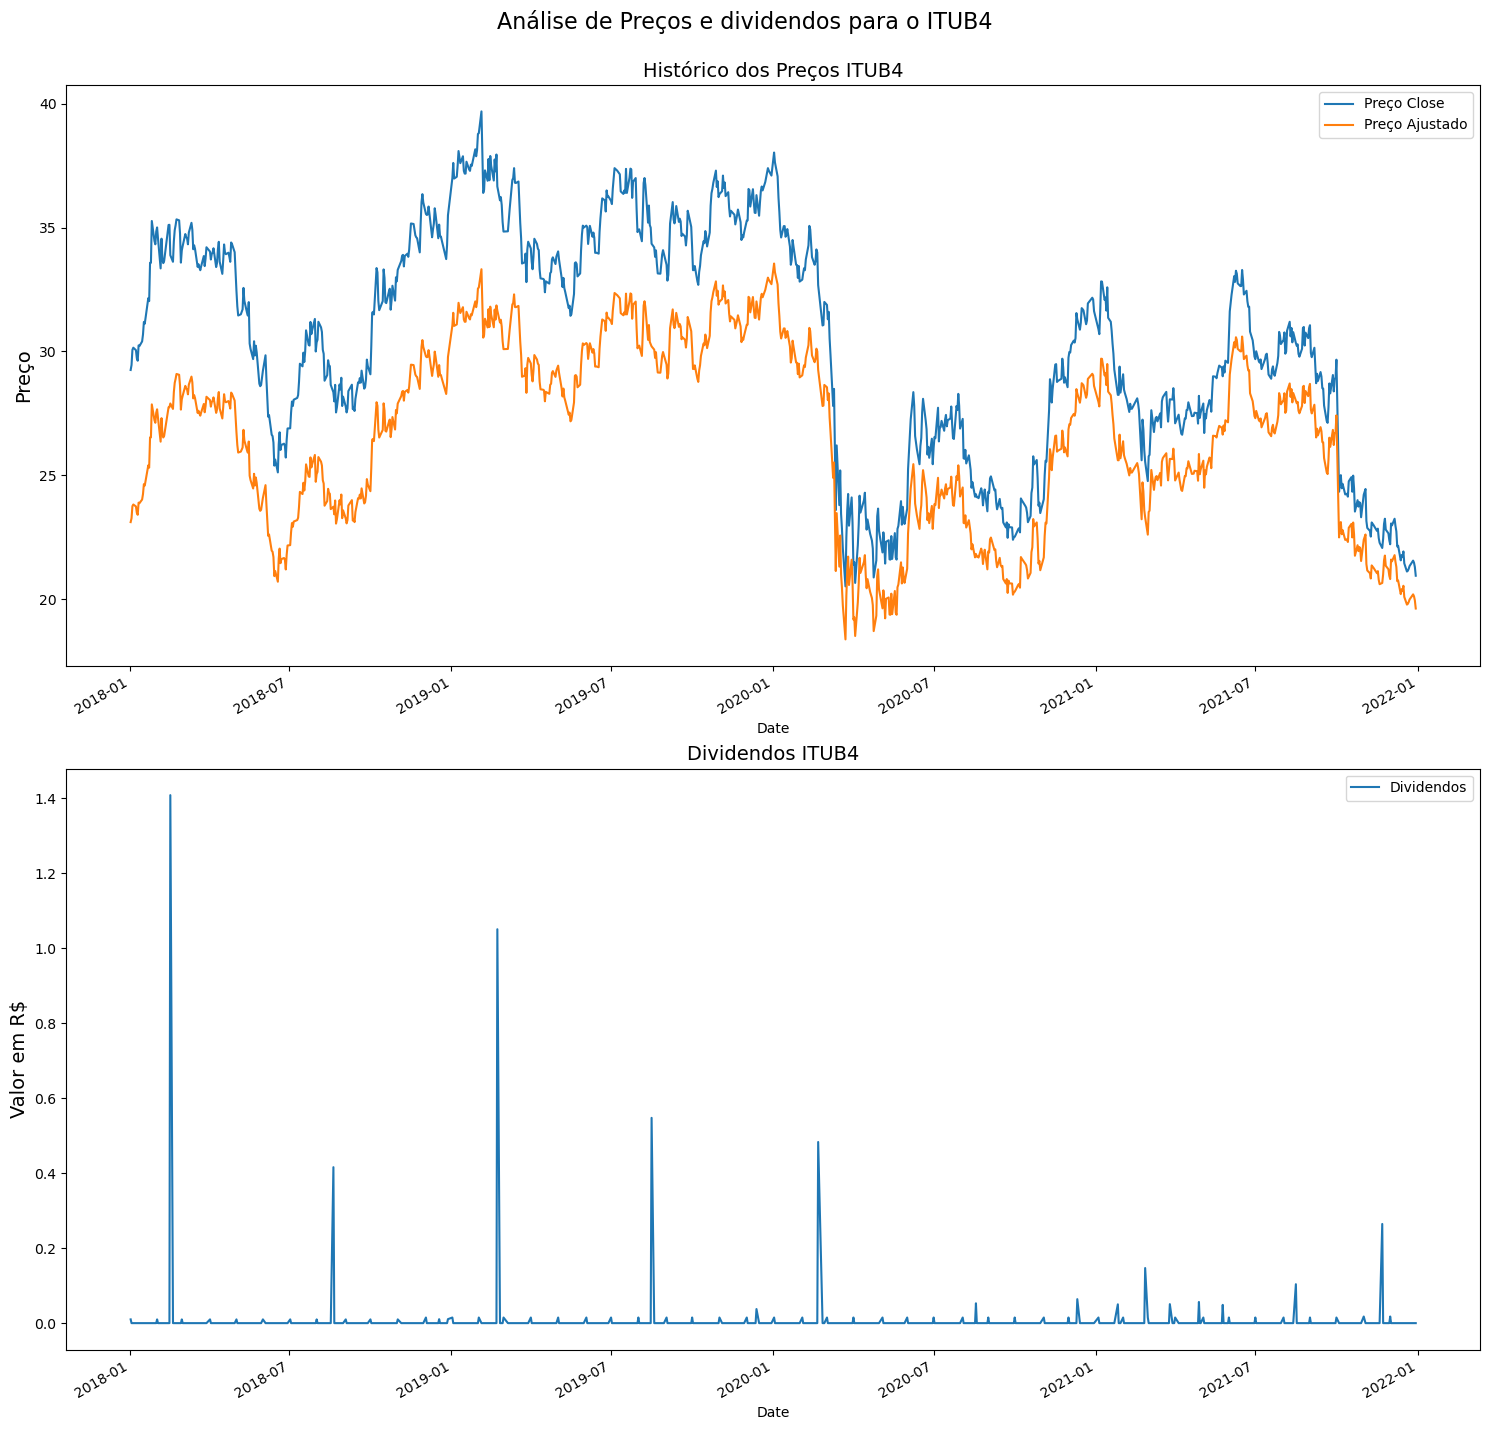

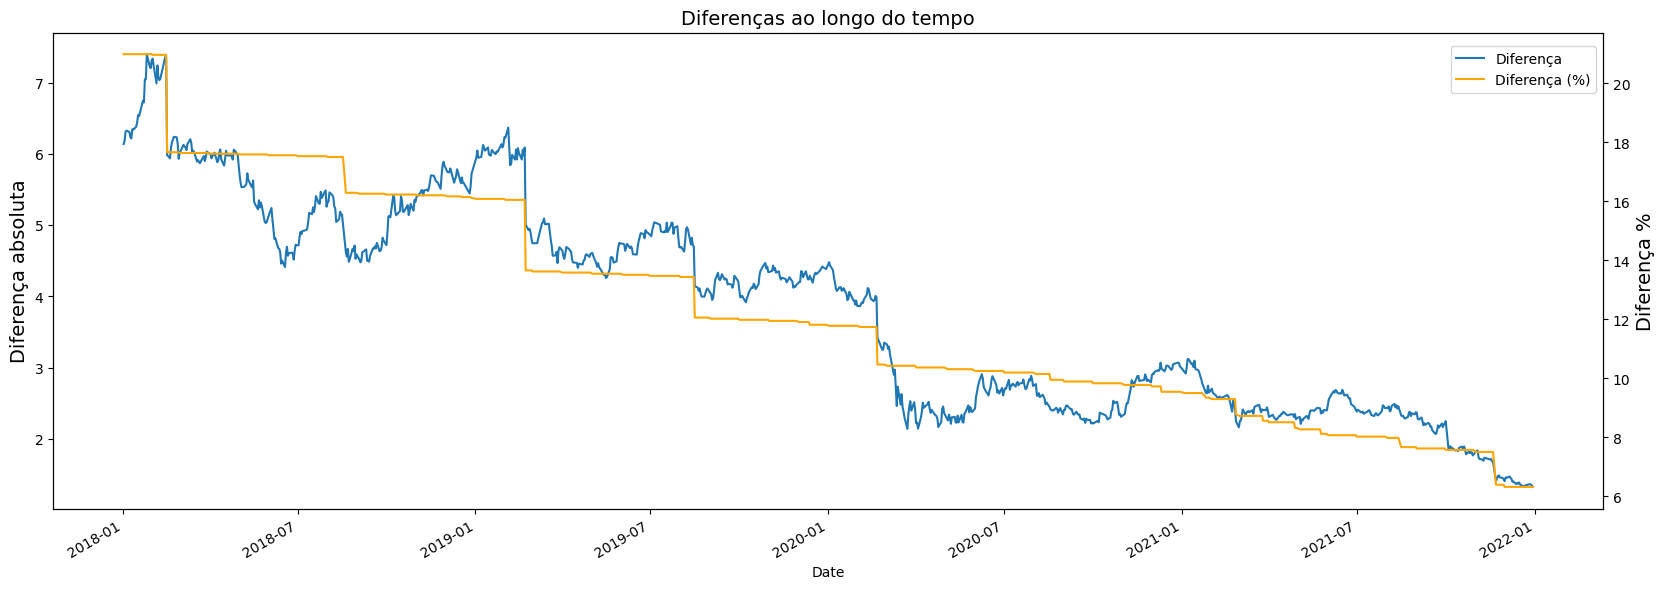

In [11]:
#Criação das figuras para gráficos de Preço e Dividendos

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

fig.suptitle('Análise de Preços e dividendos para o ITUB4', y=0.95, fontsize=16)

# Gráfico de Histórico dos preços
itub_data['Close'].plot(ax=axes[0], label='Preço Close')
itub_data['Adj Close'].plot(ax=axes[0], label='Preço Ajustado')
axes[0].set_title('Histórico dos Preços ITUB4', fontsize=14)
axes[0].set_ylabel('Preço',fontsize=14)
axes[0].legend(loc='upper right')

# Gráfico dos dividendos distribuídos no período
dividends_itub.plot(ax=axes[1], label='Dividendos')
axes[1].set_title('Dividendos ITUB4', fontsize=14)
axes[1].set_ylabel('Valor em R$', fontsize=14)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#Griação das figuras para gráfico de diferenças absolutas e percentuais
fig,axs = plt.subplots(figsize=(20,7))
itub_data['Diff'].plot(ax=axs,label='Diferença')

# Plotando a diferença relativa
axs2 = axs.twinx()
itub_data['Diff %'].plot(kind='line',ax=axs2,label='Diferença (%)',color='orange')

axs.set_title('Diferenças ao longo do tempo', fontsize=14)
axs.set_ylabel('Diferença absoluta', fontsize=14)
axs2.set_ylabel('Diferença %', fontsize=14)
fig.legend(bbox_to_anchor=(0.9,0.87))
plt.show()

### Análise dos dados e possíveis conclusões

No início da série, observa-se uma diferença maior entre os preços de fechamento e os ajustados, acompanhada de um valor de dividendo mais elevado, o que reflete um maior distanciamento entre as curvas entre o início de 2018 e meados de 2020.

No período subsequente, o distanciamento entre as curvas diminui, assim como os valores dos dividendos distribuídos.

A diferença entre os preços, apresentada no gráfico "Diferenças ao longo do tempo", apresenta uma tendência decrescente, que pode ser interpretada como uma redução do valor dos dividendos e, consequentemente, um menor impacto no valor da ação (diminuição patrimonial) após as distribuições.